<center><h1><b><font color=red >Detecting COVID-19 in X-ray images </font></b></h1></center>

<h4>Comme la plupart des gens dans le monde en ce moment, nous somme préoccupés par COVID-19. Mais au lieu de rester les bras croisés et de ne rien faire à propos de la pandémie de Covid, on a décidé de nous concentrer sur les aspects qui peuvent s'attaquer à ce problème ou au moins donner une lueur d'espoir. Par conséquent, on a créé une application qui pourrait détecter COVID-19 dans les images radiographiques. </h4>

<h1><b><font color=blue >1. Importation des bibliothèques nécessaires</font></b></h1>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from pickle import dump, load
import seaborn as sns

<h1><b><font color=blue >2. Préparation et prétraitement des données</font></b></h1>


<h2><font color=blue >Fonctions à utiliser</font></h2>
<li>La fonction "transform_image" permet de charger l'image et prétraiter en la convertissant en canal RGB et en la redimensionnant en 224 X 224 pixels et retourne un tableau numpy qui contient les images normalisé(entre 0 et 1).</li><br>
<li>La fonction "submit" permet de retourner un fichier csv pour la "submission " qui contient 2 champs :Image c'est le nom de l'image radiographique et Label c'est la classe prédite pour cet ID.</li><br>
<li>La fonction "save_pickle" permet d'entregistrer le modele sous forme d'un pickle.</li>
<br>


In [2]:
def transform_image(file):
    image = Image.open(file).convert('RGB')
    image= image.resize((width, height))
    return np.array(image)/255.0

def submit(model, name):
    final = []
    for image in os.listdir(valid_path):
        result = model.predict( np.array([transform_image(os.path.join(valid_path, image))]))
        final.append((image, int(round(result[0][0]))))

    df = pd.DataFrame(final, columns=["Image","Label"])
    
    df.to_csv(name,index=False)

    
def save_pickle(obj, filename):
    with open(filename,'wb') as file :
        dump(obj, file)
        
def load_pickle(filename):
    with open(filename,'rb') as file :
        return load(file)        

<h2><b><font color=blue > Les chemins d'accès :train,test et validation datasets</font></b></h2>


In [3]:
path="kaggle"

train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

valid_path= "deep-learning-competition-cs-2020/test/test/"

<b><h2>définir les variables </h2> </b>

In [4]:
width = 224
height =224

<h2><b><font color=blue >Augmentation des données</font></b></h2>
 Plusieurs fois, la quantité de données dont nous disposons n'est pas suffisante pour effectuer correctement la tâche de classification. Dans de tels cas, nous effectuons une augmentation des données.<br><br>
<b><li>Rotation de l'image de 17 degrés</li></b>
<b><li>Zoom avant de 55%</li></b>
<b><li>Autorise le flipping horizontal</li></b>
<br>


In [5]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=17, zoom_range=0.55, horizontal_flip=True)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


<h2><b><font color=blue >Chargement d'images</font></b></h2>

In [6]:
train = train_gen.flow_from_directory(train_path, (width,height), batch_size=64, class_mode="binary")
test = test_gen.flow_from_directory(test_path, (width,height), batch_size=128, class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 682 images belonging to 2 classes.



<h2><b><font color=blue >Exemples d'images</font></b></h2>

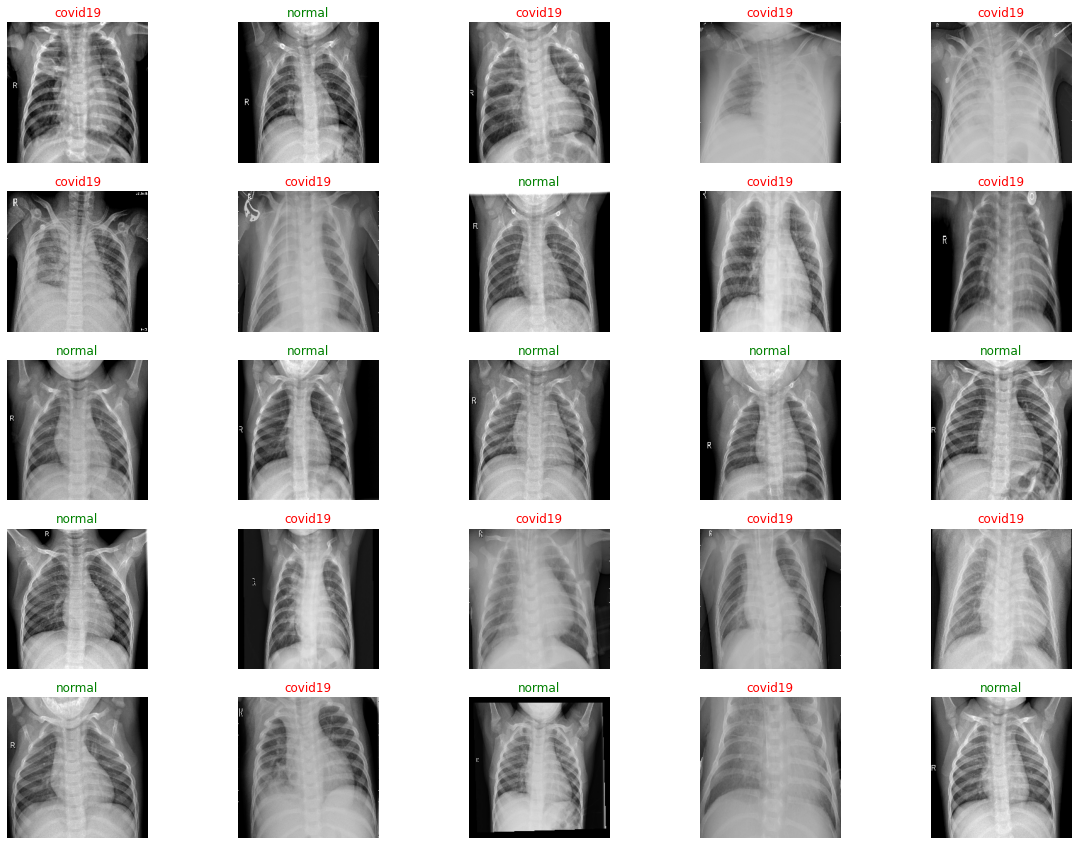

In [17]:
plt.figure(figsize=(20,15))

labels = [("normal","green"), ("covid19","red")]

images , labels_im = test[0]

for i in range(25):
    image= images[i]
    sub = plt.subplot(5,5,i+1)
    sub.imshow(image)
    tmp_lab= labels[int(labels_im[i])]
    sub.set_title(tmp_lab[0], {"color":tmp_lab[1]})
    sub.axis('off')


<h1><b><font color=blue >3. Création et optimisation du modèle</font></b></h1>

Nous avons effectué des expériences pour détecter et classifier COVID-19 à l'aide d'images radiographiques dans deux scénarios différents. 

<b><li>Architecture deep learning End-to-end (Transfer Learning )qui est composé de 2 partie:</li></b>
Partie convolutif(Extraire d’une matrice des images -> matrices de feature). Et une
partie de classification(classifier les features)

<b><li>Des algorithmes de Machine learning classiques:</li></b>
On utilise la premiere couche (CNN) pour extraire les features à partir des images.
Puis on utilise un modele de ML classique(xgboost ,random forest…)



   <h2><b><font color=black >3.1  Deep learning Architecture</font></b></h2>

 <h3><b><font color=black >3.1.1 Modéle personnalisé </font></b></h3>


In [7]:
model = keras.models.Sequential([

    keras.layers.Conv2D(16,kernel_size=(3,3), activation="relu", padding="same", input_shape=(width,height,3)),
    keras.layers.Conv2D(32,kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(32,kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.Conv2D(64,kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64,kernel_size=(3,3), activation="relu", padding="same"),
    #version 7: 
    #keras.layers.Conv2D(64,kernel_size=(3,3), activation="relu", padding="same"),

    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128,kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128,kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Flatten(),


    keras.layers.Dense(1, activation="sigmoid")
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0


<h1><b><font color=blue >4. Compilation et formation du modèle</font></b></h1>

<h4><b>Compilation du modéle avec Adam optimizer. Et nous utiliserons  «BinaryCrossentropy» car il s'agit d'un problème de classification de 2 classes.</b></h4>

In [25]:
model.compile(optimizer="adam",loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"] )

In [26]:
def scheduler(epoch):
      if epoch < 14:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


<h4><b>Maintenant, nous allons commencer notre processus de formation de réseau neuronal.</b></h4>

In [27]:
history = model.fit(train, epochs=18, steps_per_epoch=64, validation_data=test, validation_steps=7, callbacks= [ModelCheckpoint('best_model', save_best_only=True), callback])

Epoch 1/18
64/64 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.7168WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: best_model/assets
64/64 [==============================] - 104s 2s/step - loss: 0.5413 - accuracy: 0.7168 - val_loss: 0.5003 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 2/18
64/64 [==============================] - 107s 2s/step - loss: 0.4559 - accuracy: 0.8020 - val_loss: 0.3986 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 3/18
64/64 [==============================] - 105s 2s/step - loss: 0.4273 - accuracy: 0.8223 - val_loss: 0.4007 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 4/18
64/64 [============================

<h3><b><font color=black >Evaluation </font></b></h3>


In [30]:
model.evaluate(test, steps=7)

7/7 [==============================] - 8s 1s/step - loss: 0.1865 - accuracy: 0.9272


[0.18651457130908966, 0.9271605014801025]

 <h3><b><font color=black >Entregistrement des données</font></b></h3>


In [29]:
submit(model, "submit122.csv")

In [33]:
keras.models.save_model(model, './models/model122')

INFO:tensorflow:Assets written to: .models/model122/assets


In [57]:
save_pickle(history.history,"history_model_1.pckl")


<h1><b><font color=blue >5. Évaluation du modèle</font></b></h1>

In [29]:
his = load_pickle("history_model_1.pckl")

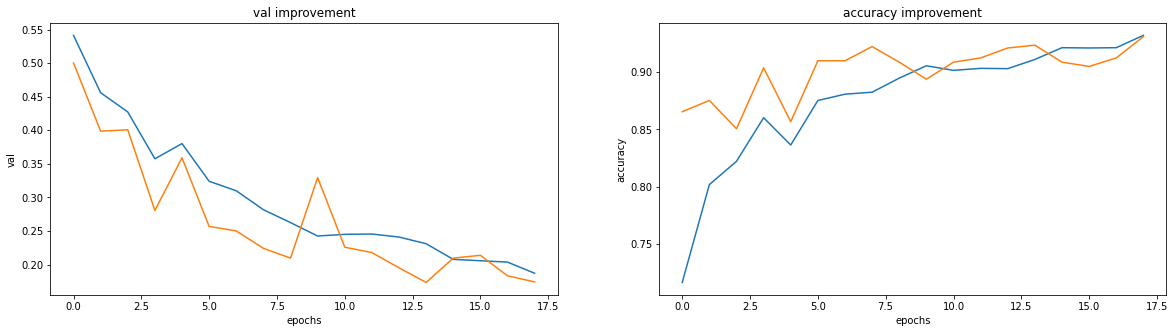

In [75]:
ax1 = plt.figure(figsize=(20,5));

ax1 = plt.subplot(1,2,1);
l1 = sns.lineplot(range(len(his['loss'])), his["loss"], ax= ax1) #blue 
l2= sns.lineplot(range(len(his['loss'])), his["val_loss"], ax= ax1) #orange 
ax1.set_title("val improvement", {"fontsize":12})
ax1.set_xlabel("epochs")
ax1.set_ylabel("val")

ax2 = plt.subplot(1,2,2);
ax2.set_title("accuracy improvement", {"fontsize":12})
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
l3= sns.lineplot(range(len(his['loss'])), his["accuracy"], ax= ax2); #blue
l4= sns.lineplot(range(len(his['loss'])), his["val_accuracy"], ax=ax2); #orange 


 <h3><b><font color=black >3.1.2 Utilisation d'un modéle pré-entraînés + autres couches </font></b></h3>

In [31]:
dense = keras.applications.DenseNet121(include_top=False, input_shape=(width, height,3))

# Boucle sur les couches du modèle de base afin qu'elles ne soient pas mises à jour lors du premier processus de formation
for layer in dense.layers:
    layer.trainable=False
cnn = keras.models.Sequential([
    dense, 
    keras.layers.Flatten()
])

model2 = keras.models.Sequential([
    cnn,
    keras.layers.Dense(1, activation="sigmoid")
])

In [32]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 50176)             7037504   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 50177     
Total params: 7,087,681
Trainable params: 50,177
Non-trainable params: 7,037,504
_________________________________________________________________


<h1><b><font color=blue > Compilation et formation du modèle 2</font></b></h1>

In [33]:
model2.compile(optimizer="adam",loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=["accuracy"] )

In [34]:
history2= model2.fit(train, epochs=12, steps_per_epoch=64, validation_data=test, validation_steps=7, callbacks= [ModelCheckpoint('best_model', save_best_only=True)])

Epoch 1/12
64/64 [==============================] - 160s 2s/step - loss: 0.8917 - accuracy: 0.8245 - val_loss: 0.3325 - val_accuracy: 0.9025
Epoch 2/12
64/64 [==============================] - 169s 3s/step - loss: 0.1939 - accuracy: 0.9268 - val_loss: 0.2369 - val_accuracy: 0.9272
Epoch 3/12
64/64 [==============================] - 110s 2s/step - loss: 0.1819 - accuracy: 0.9410 - val_loss: 0.2428 - val_accuracy: 0.9309
Epoch 4/12
64/64 [==============================] - 181s 3s/step - loss: 0.1547 - accuracy: 0.9427 - val_loss: 0.1410 - val_accuracy: 0.9494
Epoch 5/12
64/64 [==============================] - 104s 2s/step - loss: 0.1831 - accuracy: 0.9365 - val_loss: 0.2135 - val_accuracy: 0.9469
Epoch 6/12
64/64 [==============================] - 121s 2s/step - loss: 0.1742 - accuracy: 0.9390 - val_loss: 0.4802 - val_accuracy: 0.8951
Epoch 7/12
64/64 [==============================] - 120s 2s/step - loss: 0.2014 - accuracy: 0.9352 - val_loss: 0.1725 - val_accuracy: 0.9506
Epoch 8/12
64

<b><h3> Evaluation </h3><b>

In [35]:
model2.evaluate(test, steps=7)

7/7 [==============================] - 8s 1s/step - loss: 0.1666 - accuracy: 0.9679


[0.16664014756679535, 0.9679012298583984]

<b><h3> Enregistrement des données </h3></b>

In [36]:
submit(model2, "submit122.csv")

In [37]:
keras.models.save_model(model2, './models/model122_2')

INFO:tensorflow:Assets written to: ./models/model122_2/assets


In [38]:
save_pickle(history2.history,"history_model_2.pckl")

<h1><b><font color=blue >Evaluation du modéle 2</font></b></h1>

In [39]:
his2 = load_pickle("history_model_2.pckl")

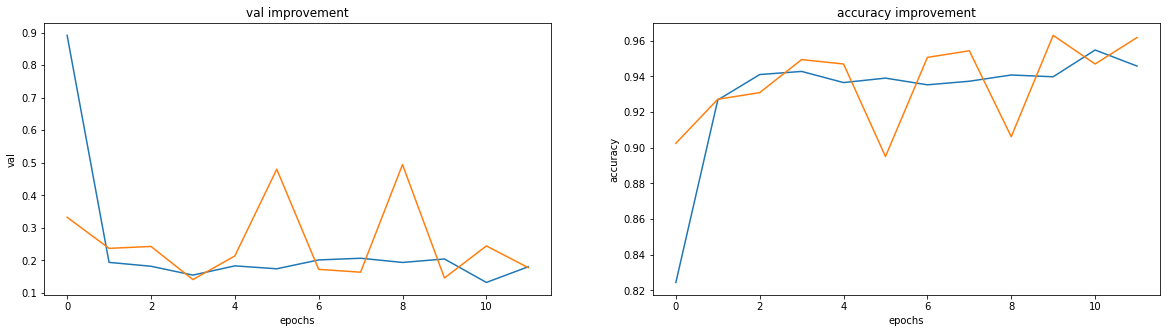

In [40]:
ax1 = plt.figure(figsize=(20,5));

ax1 = plt.subplot(1,2,1);
l1 = sns.lineplot(range(len(his2['loss'])), his2["loss"], ax= ax1) #blue 
l2= sns.lineplot(range(len(his2['loss'])), his2["val_loss"], ax= ax1) #orange 
ax1.set_title("val improvement", {"fontsize":12})
ax1.set_xlabel("epochs")
ax1.set_ylabel("val")

ax2 = plt.subplot(1,2,2);
ax2.set_title("accuracy improvement", {"fontsize":12})
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
l3= sns.lineplot(range(len(his2['loss'])), his2["accuracy"], ax= ax2); #blue
l4= sns.lineplot(range(len(his2['loss'])), his2["val_accuracy"], ax=ax2); #orange 